# Alunos
* Arthur Severo
* Victor Le Roy

#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [2]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [3]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [4]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [5]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [6]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [7]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [8]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

626     3
4709    2
8216    4
2418    1
6735    3
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [7]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

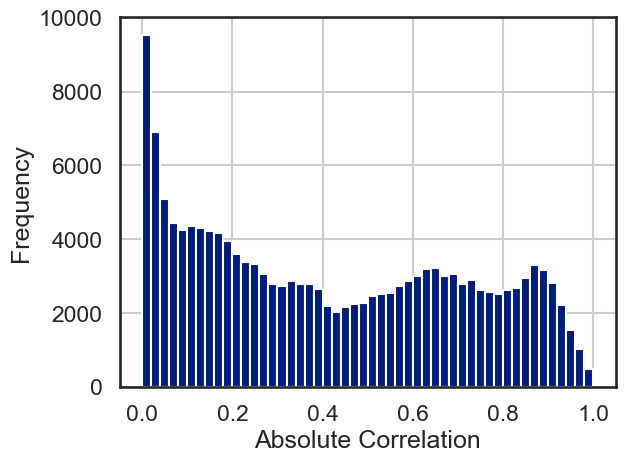

In [12]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [13]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [15]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [9]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty=None).fit(X_train, y_train)
lr.coef_

array([[ -74.99258775,   11.56119732,   16.53422018, ...,  849.32406958,
        -345.72919745, -129.19100975],
       [-251.27219349,  -98.42601793,   18.6513434 , ..., -113.83250652,
        -100.52853381,  -63.56480618],
       [ 109.53041248,   80.52822678,   92.62851002, ..., -325.53780435,
         229.19630286,   26.277458  ],
       [  14.25886185,  -18.50007734,    1.62222455, ..., -153.38161852,
          29.66262118,   85.00954482],
       [ 142.11830765,   30.35151423,    3.29850035, ..., -278.52022022,
         -14.27120958,   -7.80215534],
       [  60.35719927,   -5.51484307, -132.73479851, ...,   21.94808003,
         201.6700168 ,   89.27096845]])

In [10]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l1.coef_

array([[-2.75099979e-01,  3.31367330e+00,  3.85752937e-01, ...,
         3.87473954e+00, -4.79438057e-03, -6.61043907e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.88670975e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.23946515e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.31948964e-01,  0.00000000e+00,  0.00000000e+00],
       [-3.12254120e-01,  0.00000000e+00,  0.00000000e+00, ...,
         4.06760203e-01,  2.05635399e+00,  2.24933957e+00]])

In [20]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)
lr_l2.coef_

array([[-8.51362712e-02,  3.81904426e-02,  3.63766397e-02, ...,
         1.93173856e+00, -1.00084016e+00, -2.54733522e-01],
       [-5.47656008e-01, -2.18015756e-01, -2.76046831e-02, ...,
        -8.94933949e-01, -6.54948644e-01, -2.00533743e-01],
       [ 3.88615919e-01,  1.32824131e-01,  2.24556830e-01, ...,
        -9.75978469e-01,  1.60693329e+00,  3.72649730e-01],
       [-3.51487374e-02, -1.99400686e-02,  6.90853119e-03, ...,
        -1.94339541e-01, -1.15641003e-01,  7.69356014e-02],
       [ 3.65056568e-01,  1.26200902e-01, -1.56405229e-03, ...,
        -4.43430391e-01, -2.67821485e-01, -2.15196599e-01],
       [-8.57314704e-02, -5.92596500e-02, -2.38673266e-01, ...,
         5.76943791e-01,  4.32318002e-01,  2.20878534e-01]])

In [20]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
lr_newton = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=10000).fit(X_train, y_train)

In [21]:
lr_lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train, y_train)

In [22]:
lr_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', max_iter=10000).fit(X_train, y_train)

In [51]:
lr_saga_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', max_iter=10000).fit(X_train, y_train)

In [24]:
lr_saga_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

Analise:
* Foi possível utilizar a penalidade L1 apenas em "liblinear" e "saga", enquanto o L2 foi utilizado em "newton-cg", "lbfgs" e "sag" e "saga"
* As execuções utilizando solver "saga" utilizando a penalidade L1 foi a mais lenta, enquanto "newton-cg" foi a mais rápida
* As execuções que utilizam a penalidade L1 tendem a demorar mais dos que as que utilizam a L2


Imagem contendo o tempo de exeução de cada solver e penalidade:

![exec_time](imgs/exec_time.png)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [22]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                              \
             0           1           2           3           4           5   
74  -77.025785  -55.495645   89.842054  -35.073753   -0.253787   78.006916   
509 -67.204620  -75.965675  -52.754949  -34.932720  202.429504   28.428459   
174  43.041491  154.232885 -142.163047   82.273101   48.850445 -186.234875   
199  47.495838 -116.165594  102.892013  356.990611  -47.151192 -344.061676   
554  -0.444791   57.808886  -41.168044    0.196821  -96.329641   79.936770   
106 -90.039413  404.074084 -210.593185   55.935962 -175.504620   16.127171   
38   43.045513 -249.399105   87.231463  104.255565 -113.476511  128.343075   
271 -95.901560 -202.565125  -88.709192   38.653806  126.834160  221.687910   
118  53.318861  147.566251 -166.337009   64.477939  -51.865252  -47.160789   
383 -15.981759    7.905431   23.523797    2.665239   74.561768  -92.674476   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
74  -0.044538  0.000000  0.057413 -0.188719 -0.316097  0.000000 -0.115973   
509 -0.024921  0.000000  0.000000 -0.071048  0.822944  0.000000 -0.032389   
174  0.016299  0.000000 -0.186096  0.000000  0.246384 -0.008025  0.060478   
199 -1.428310  0.483596  0.207239  1.011053  1.811554 -2.726124 -0.155658   
554 -0.467198  0.162511  0.000000  0.000000 -0.350161  0.401397 -0.087440   
106 -0.968206  0.188822 -0.377338  0.000000 -3.128823 -0.088920 -0.219994   
38   0.819002 -1.130996  1.438722  0.000000 -0.634262  0.996916  0.170170   
271 -0.018338 -1.204040 -0.656517  0.000000  0.233618  2.644545  0.007093   
118  0.445503  1.446794 -1.574301  0.190204  0.000000 -1.495841  0.056120   
383  0.073245  0.000000  0.000000  0.000000  0.475718 -0.066373 -0.022859   

                                                       
            1         2         3         4         5  
74  -0.195424  0.392680 -0.237997 -0.103836  0.260550  
509 -0.106810 -0.064572 -0.465275  0.614133  0.054914  
174  0.303122 -0.305661  0.176826  0.198901 -0.433666  
199  0.007745  0.353538  0.731446  0.056401 -0.993471  
554  0.170011 -0.107381  0.037631 -0.145753  0.132932  
106  0.900265 -0.422837  0.026455 -0.440218  0.156329  
38  -1.006450  0.483130  0.515864 -0.286779  0.124065  
271 -0.363575 -0.047924 -0.265266  0.221866  0.447807  
118  0.551968 -0.833774  0.447065  0.046701 -0.268079  
383 -0.010441 -0.016387 -0.025997  0.253822 -0.178139

Analise visualizada pela tabela:
* cada LR recebeu 6 coeficientes, em que cada um dos coeficientes representam um dos atributos encodados de 0 - 5
* Cada linha representa as features
* Os exemplos na regressão linear demonstram muita variância devido a não penalidade das features, uma vez que ele apenas adiciona ou remove as mesmas
* O L1 obteve vários resultados com valor nulo, além de baixa variância
* O L2 também obteve baixa variação em seus resultados

Prepare six separate plots for each of the multi-class coefficients.

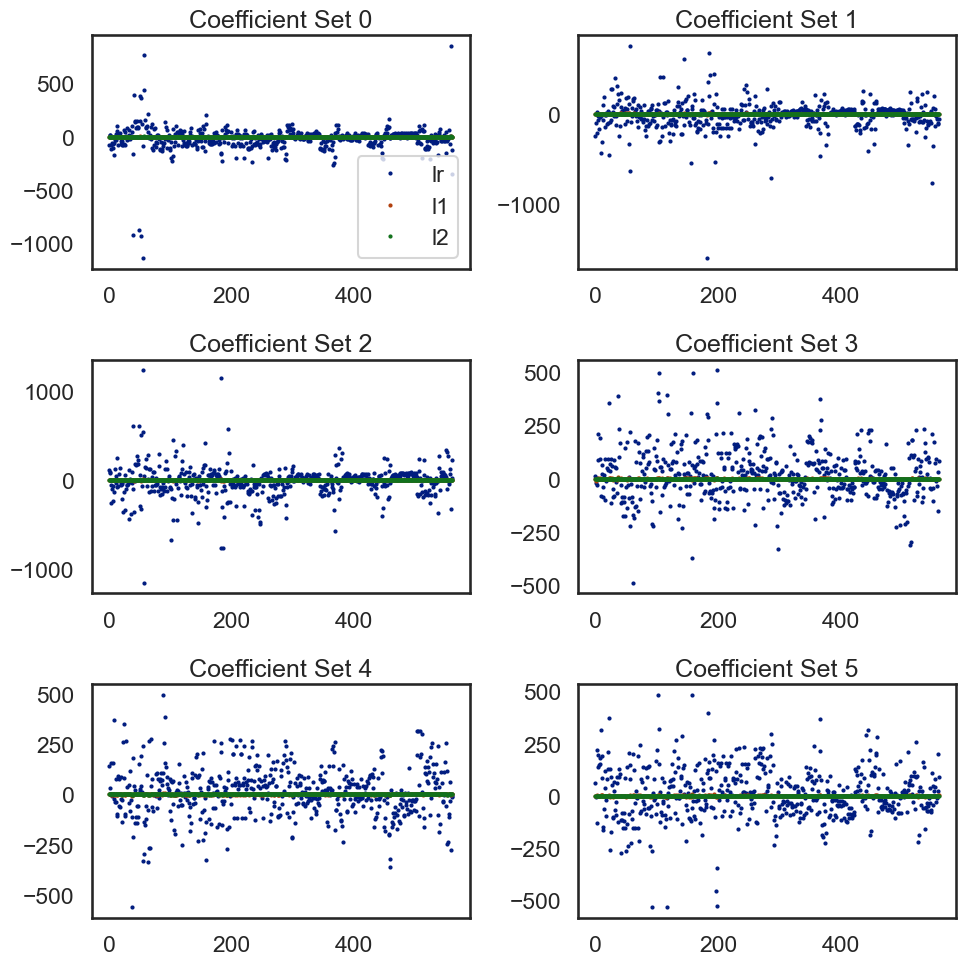

In [26]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
         
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




Analise do grafico:
* Percebe-se que LR está variando bastante
* L1 e L2 tiveram baixa variação
* L2 houve uma variação inferior à L1

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [35]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [28]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998970,0.999998
1,1.0,0.999580,0.999654
2,1.0,0.995444,0.998873
3,1.0,0.999193,0.997829
4,1.0,0.999919,0.999307


Analise:
* Todos os métodos obtiveram rsultados muito bons na predição

## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [30]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.981546,0.983835,0.983485
recall,0.981553,0.983819,0.983495
fscore,0.981546,0.983815,0.983488
accuracy,0.981553,0.983819,0.983495
auc,0.988812,0.990144,0.989983


Analise:
* Todos os resultados ficaram muito próximos e próximos 1
* Precision: L2 foi o maior
* Recall: L1 e L2 foram identicos e foram os melhores
* Fscore: L1 foi o vencendor entre os três
* Accuracy: L1 e L2 foram identicos e foram os melhores
* AUC: L2 foi o vencedor


## Question 8

Display or plot the confusion matrix for each model.

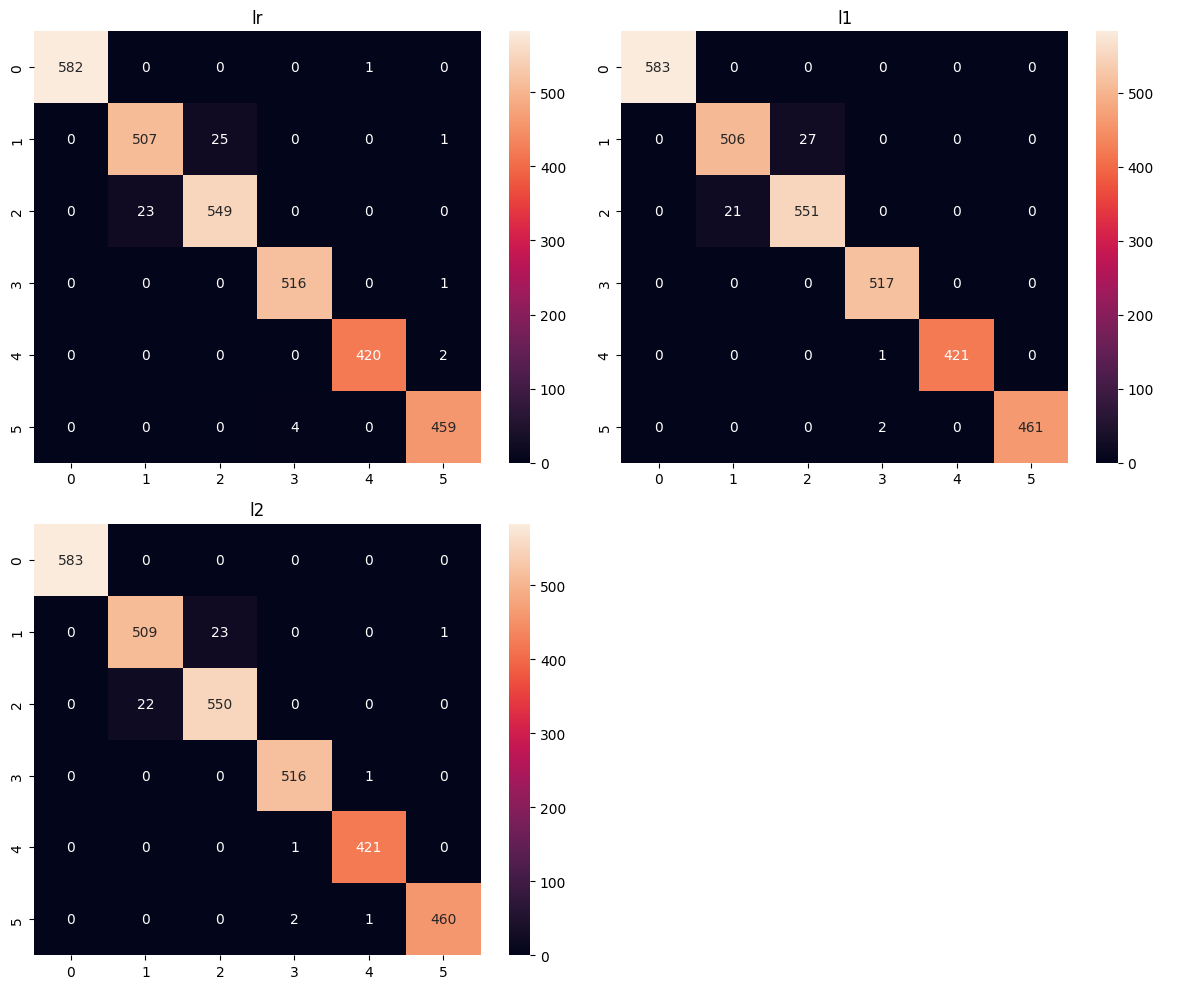

In [43]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


Analise:
* Todos os métodos obtiveram excelentes resultados para todas as features
* L2 foi o que menos errou para a feature 1 e para a feature 2, o L1 foi o melhor --> Essas foram as features observadas, pois foram as que obtiveram a maior taxa de erro ao comparado com as outras

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


Analise:
* O VarianceThreshold elimina as features que possuem uma variância abaixo de um determinado limiar

 Repeat Model building with new training data after removing higly correlated columns

In [27]:
# Try standard, L1 and L2 Logistic regression
lr_new = LogisticRegression(max_iter=100000, penalty=None).fit(X_train_new, y_train_new)

In [29]:
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=100000).fit(X_train_new, y_train_new)

In [30]:
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

In [12]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
lr_newton_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=10000).fit(X_train_new, y_train_new)

In [13]:
lr_lbfgs_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train_new, y_train_new)

In [14]:
lr_sag_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', max_iter=10000).fit(X_train_new, y_train_new)

In [15]:
lr_saga_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', max_iter=10000).fit(X_train_new, y_train_new)

In [16]:
lr_saga_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=10000).fit(X_train_new, y_train_new)

Analise:
* Foi necessário aumentar o número de iterações máximas da lr e lr_l1 por que o valor padrão não foi suficiente para convergir
* Em todos os casos o tempo de execução diminuiu consideravelmente ao se comparar com o primeiro modo de execução utilizado

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [24]:
# Combine all the coefficients into a dataframe
coefficients_new = list()
for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

lr                                                              \
              0           1           2           3           4           5   
421   -1.035339   29.050113   28.288590  -40.862957   64.430421  -79.870828   
386   -0.969718    4.554775   49.223373 -119.148615   92.262729  -25.922545   
531  -27.707510   79.876819 -154.980248   84.341435   60.701983  -42.232480   
394  -20.677715   -7.853807   25.653560   -7.208533   53.526104  -43.439609   
141  -70.406575  125.342472 -207.810434 -229.404041   94.714357  287.564220   
59   152.132276   69.121593  150.500311 -106.820933 -151.593423 -113.339824   
296   26.290703   13.961671  -60.984812 -221.290238  178.592727   63.429949   
329   -3.054286   29.386791   16.666114   24.102675  -27.864619  -39.236675   
281  -13.093312  -28.988932   -0.597816  -99.444618   89.978111   52.146566   
325  -30.068584    1.876375  -12.017173  -90.584022   84.415579   46.377825   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
421 -0.478381  0.000000  0.000000  0.000000  0.122542 -0.044696 -0.020693   
386 -0.077608  0.000079  0.000000  0.000000  0.727970  0.003302 -0.016547   
531 -0.136647  0.729313  0.000000  0.355656  0.498571 -0.422497  0.040475   
394 -0.042867  0.000000  0.000000  0.000000  0.060776 -0.159555 -0.022260   
141 -0.177639  0.000000  0.000000 -3.920809  0.295840  2.930439 -0.025841   
59   0.335804  0.148822  0.957773  0.040214 -0.037591 -0.000579  0.163705   
296 -1.100811  0.574290 -1.342852  0.000000  1.580874  1.478068 -0.041218   
329 -0.005726  0.000000  0.000000  0.008010 -0.262995  0.000000 -0.014206   
281 -0.101185  0.000000  0.000000 -0.476530  0.255286 -0.071286  0.016868   
325 -0.087039  0.000000  0.000000  0.000000 -0.003120 -0.092566 -0.016285   

                                                       
            1         2         3         4         5  
421 -0.010186 -0.036712 -0.083314  0.286035 -0.135128  
386 -0.059172  0.017179 -0.285603  0.301376  0.042768  
531  0.364429 -0.516604  0.230453  0.033599 -0.152352  
394 -0.046656  0.005445 -0.040326  0.144237 -0.040440  
141  0.358317 -0.491317 -0.988015  0.200227  0.946629  
59   0.024538  0.138976 -0.081448 -0.162979 -0.082791  
296  0.182507 -0.276922 -0.569737  0.345584  0.359786  
329  0.026966 -0.054333  0.115902 -0.067435 -0.006894  
281 -0.082558 -0.047751 -0.311398  0.319887  0.104952  
325  0.010132 -0.060510 -0.149368  0.118142  0.097890

Prepare six separate plots for each of the multi-class coefficients.

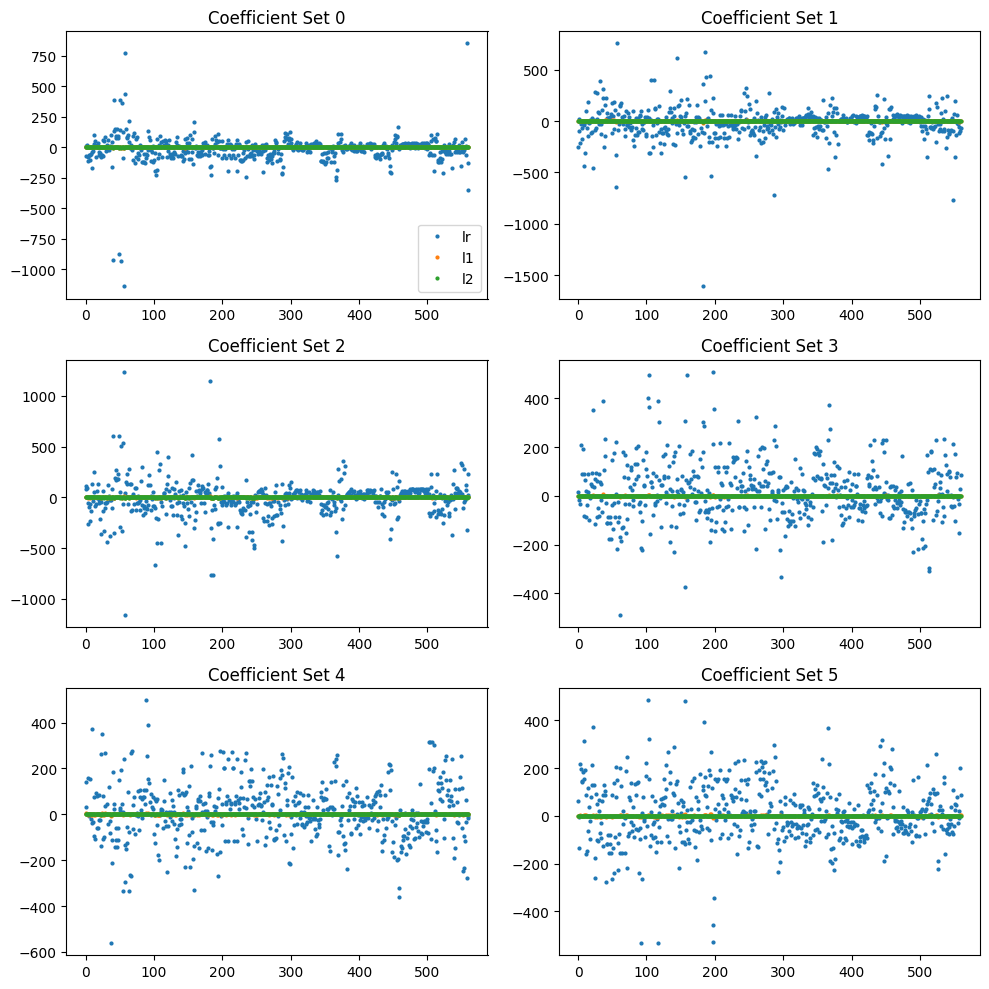

In [25]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients_new.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
         
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

Analise:
* Os coeficientes obtidos apresentaram valores inferioes comparado aos coeficientes obtidos no primeiro modo de execução
* L2 continua sendo o que menos apresenta variação, juntamente com L1

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [31]:
# Predict the class and the probability for each
y_pred_new = list()
y_prob_new = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))

y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [44]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998975,0.999998
1,1.0,0.999598,0.999654
2,1.0,0.995341,0.998873
3,1.0,0.999177,0.997829
4,1.0,0.999921,0.999307


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [38]:
# Calculate the error metrics as listed above
metrics_new = list()
cm_new = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred_new[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred_new[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test_new, y_pred_new[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)


In [ ]:
#Run the metrics
metrics_new

,lr,l1,l2
precision,0.937379,0.937335,0.936643
recall,0.937217,0.937217,0.936570
fscore,0.937221,0.937229,0.936555
accuracy,0.937217,0.937217,0.936570
auc,0.962353,0.962271,0.961954


Analise:
* O método obteve valores próximos a 90% em todos os casos, o que demonstra que o sistema está funcionando e predizendo bem os dados
* Na maioria dos casos, o L1 foi melhor, logo o mais preciso nas predições

## Question 13

Display or plot the confusion matrix for each model.

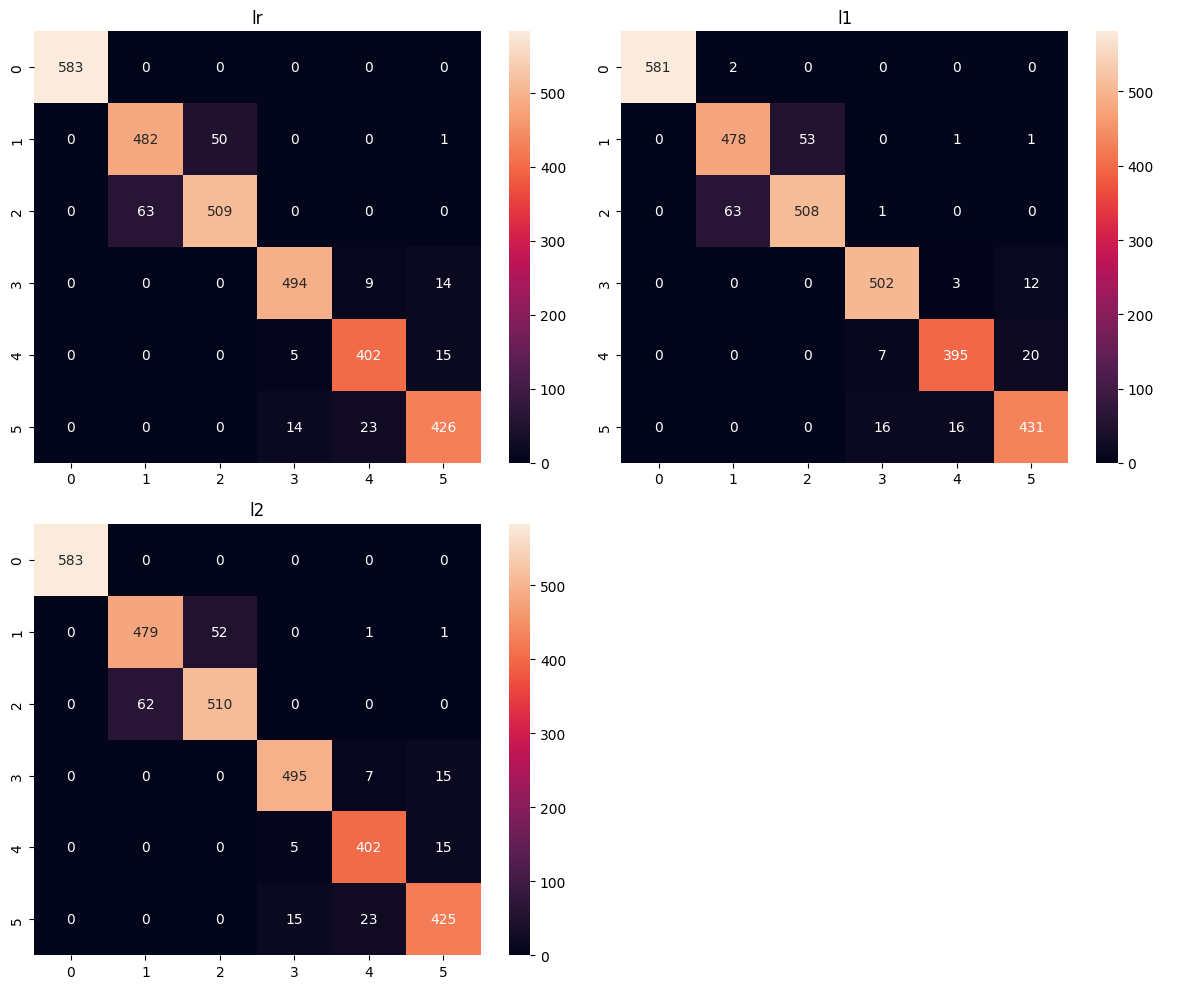

In [42]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab)
    
plt.tight_layout()

Analise:
* Verifica-se que a quantidade de erros foi elevada, porém ainda assim os resultados foram aceitáveis para a maioria dos casos

In [ ]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [40]:
metrics - metrics_new

,lr,l1,l2
precision,0.044167,0.046523,0.046843
recall,0.044337,0.046602,0.046926
fscore,0.044325,0.046601,0.046933
accuracy,0.044337,0.046602,0.046926
auc,0.026459,0.027877,0.028028


Analise:
* A partir deste resultado, verifica-se que o primeiro metodo, em todas métricas, obteve melhores resultados ao se comprar com o segundo método

In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

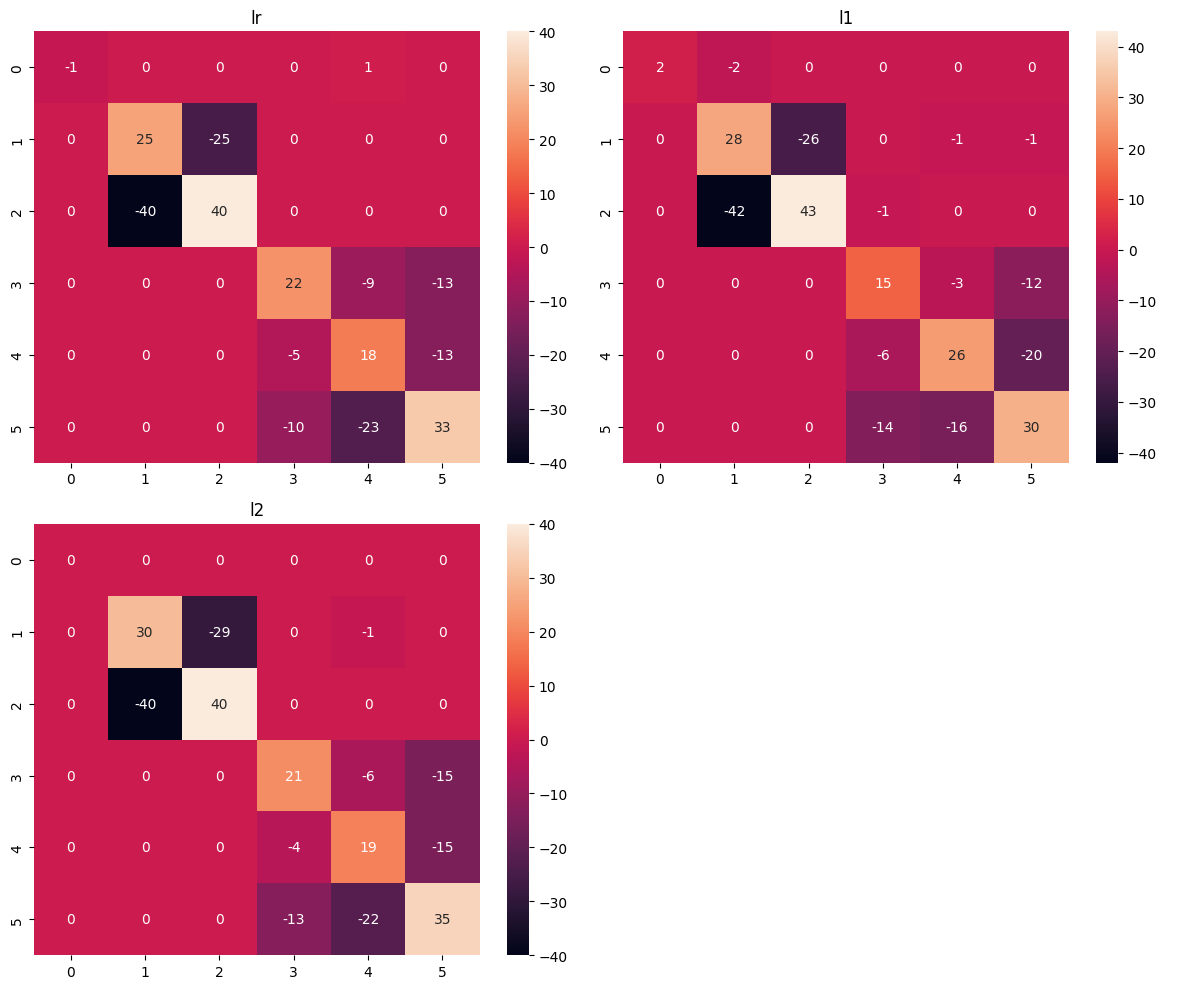

In [41]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab] - cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab)
    
plt.tight_layout()

Analise:
* Os resultados do primeiro método de predição obteve melhores resultados do que o segundo método
* O segundo método errou mais nas predições, o que demostra que o sistema se confundiu mais do que o esperado